#### In this we aim to simulate a scenario similar to https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf?__blob=publicationFile. Some advances may be taken into account

In [36]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
dates = pd.date_range('2020-01-27', '2021-12-31')  #data range for the whole year starting from the first point for which we have german data

The system of differential equations is given by: <br/>
$\dot{S}=\frac{\beta I S}{N}$ <br/>
$\dot{E}=\delta \cdot I$ <br/>
$\dot{R}=\gamma \cdot I$ <br/>
$\dot{I}=\frac{\beta I S}{N}-\dot{E}-\dot{R}$ <br/>

with $N$ as total population, $S(t)$ as susceptible people at time $t$, $E(t)$ as people dying at time $t$, $R(t)$ as people who are already recovered from the disease and have immunity and $I(t)$ as infected (and infectious) people. The paramters which have to be assumed are $\beta$ which is the contact rate of infectious and susceptible, $\gamma$ which is the recovery rate and $\delta$ which is the death rate. This is a system of coupled ordinary differential equations of first order and can therefore be solved with standard ODE-solvers.

In [89]:
def deriv(t, y):
    S, E, I, R = y
    dSdt = -1/N*beta*I*S
    dEdt = delta*I
    dRdt = gamma*I
    dIdt = 1/N*beta*I*S-dEdt-dRdt
    return dSdt, dEdt, dIdt, dRdt

In [90]:
beta = 2/10  # contact rate: given by RKI, a patient is 10 days infectious and infects 2 people during this time
gamma = 0.97/9  #recovery rate: 0.97 percent survive while the average infection lasts for 14 days
delta = 0.03/14  #death rate: 1-gamma
N = 8*10e7  #german population

In [91]:
sol = solve_ivp(deriv, (0, 260), y0=[N-1, 0, 1, 0], t_eval = np.linspace(0, 260, 261))

In [92]:
dates[sol.t.astype(int)]

DatetimeIndex(['2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03',
               '2020-02-04', '2020-02-05',
               ...
               '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07',
               '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11',
               '2020-10-12', '2020-10-13'],
              dtype='datetime64[ns]', length=261, freq=None)

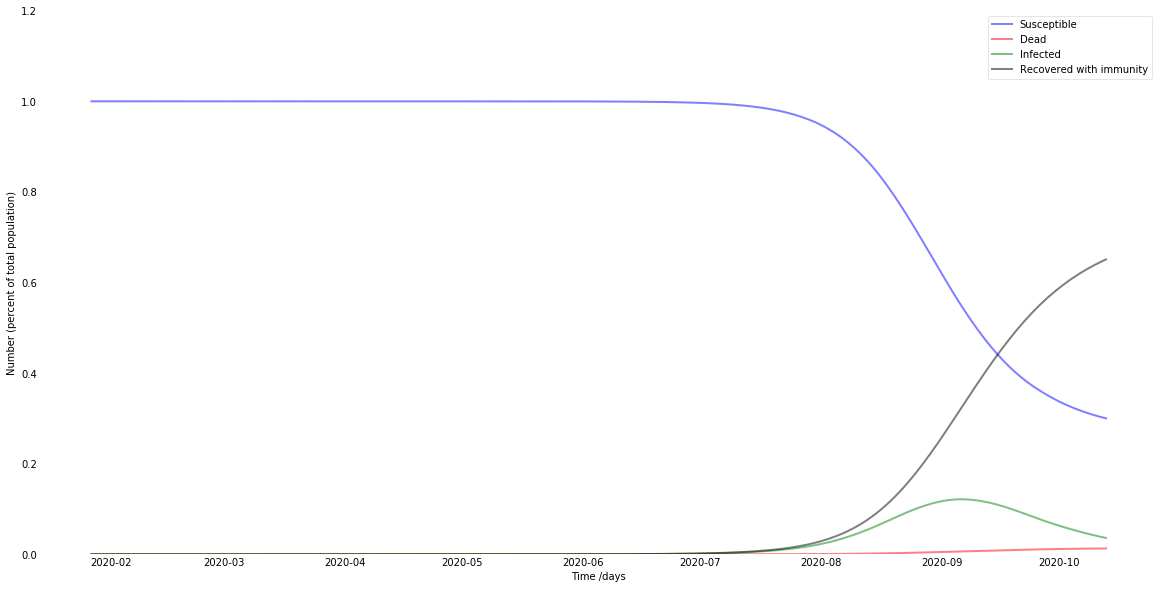

In [93]:
def plotting_standards(ax):
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (percent of total population)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
def plot_one_dim(sol):
    fig = plt.figure(facecolor='w', figsize=(20,10))
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(dates[sol.t.astype(int)], sol.y[0,:]/N, 'b', alpha=0.5, lw=2, label=f'Susceptible')
    ax.plot(dates[sol.t.astype(int)], sol.y[1,:]/N, 'r', alpha=0.5, lw=2, label=f'Dead')
    ax.plot(dates[sol.t.astype(int)], sol.y[2,:]/N, 'g', alpha=0.5, lw=2, label=f'Infected')
    ax.plot(dates[sol.t.astype(int)], sol.y[3,:]/N, 'black', alpha=0.5, lw=2, label=f'Recovered with immunity')
    plotting_standards(ax)

plot_one_dim(sol)

#### Making the one dimensional case time dependent

The RKI assumes as sinusoidal form of which has its minimum at the end of June.

In [140]:
def sinusoidal_decay(seasonality, length):
    R0 = 2
    if seasonality == 'weak':
        a = 0.6
    elif seasonality == 'strong':
        a = 1.33
    else:
        raise ValueError(f"seasonality {seasonality} not found")
    return -a*np.sin([2*np.pi*i/(2*length) for i in range(length)]) + R0

In [123]:
beta = 2  # contact rate: given by RKI, a patient is 10 days infectious and infects 2 people during this time
gamma = 0.97/9  #recovery rate: 0.97 percent survive while the average infection lasts for 14 days
delta = 0.03/14  #death rate: 1-gamma
N = 8*10e7  #german population

In [137]:
length = 460
beta = sinusoidal_decay('weak', length)/7

def deriv_time_dep(t, y):
    S, E, I, R = y
    dSdt = -1/N*beta[int(t)]*I*S
    dEdt = delta*I
    dRdt = gamma*I
    dIdt = 1/N*beta[int(t)]*I*S-dEdt-dRdt
    return dSdt, dEdt, dIdt, dRdt

In [138]:
sol = solve_ivp(deriv_time_dep, (0, length-1), y0=[N-1, 0, 1, 0], t_eval = np.linspace(0, length-1, length))

In [ ]:
class PandemySimulatorBase:
    def __init__(beta, gamma, delta, N, timesteps=400):
        self.beta = beta if len(beta) == timesteps else 
        self.gamma = gamma
        self.delta = delta
        self.N = N
    
    def simulate_SEIR():
        def deriv_time_dep(t, y):
            S, E, I, R = y
            dSdt = -1/N*self.beta[int(t)]*I*S
            dEdt = self.delta*I
            dRdt = self.gamma*I
            dIdt = 1/N*self.beta[int(t)]*I*S-dEdt-dRdt
            return dSdt, dEdt, dIdt, dRdt
        

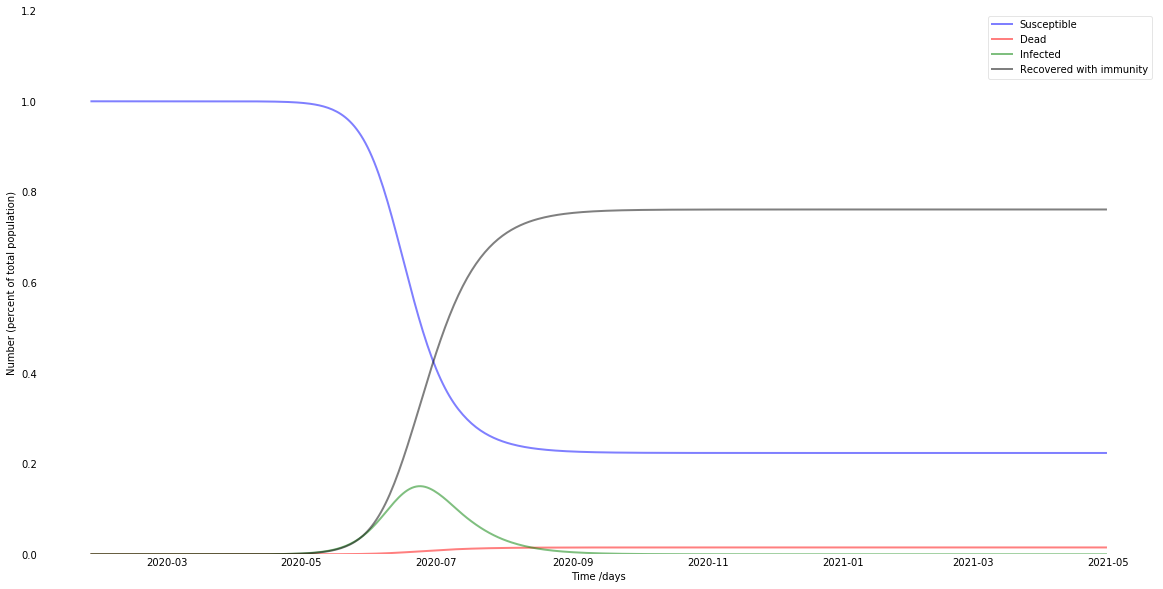

In [139]:
plot_one_dim(sol)

#### Multi Dimensional Case

In principle the equations given above can be extended to matrix equations then $S, E, I, R$ are vectors and $\mathbf{\beta}, \mathbf{\gamma}$ and $\mathbf{\delta}$ become matrices.
The whole system then results in: <br/>
$\dot{S}=\frac{(I \cdot \beta) \circ S}{N}$ <br/>
$\dot{E}=\delta \cdot I$ <br/>
$\dot{R}=\gamma \cdot I$ <br/>
$\dot{I}=\frac{(I \cdot \beta) \circ S}{N}-\dot{E}-\dot{R}$ <br/>

with $\circ$ being the Schur Hadamard product (pointwise multiplication) <br/>
While $\mathbf{\gamma}, \mathbf{\delta}       \in diag(\mathbb{R}^{N\times N})$ there is an interesting change for $\mathbf{\beta}$ (just showing the case for $N=2$:

$\begin{array}{rr}\beta_{11} & \beta_{12} \\ \beta_{21} & \beta_{22} \end{array}$.
We can now interpret each of the component of $S, E, I, R$ as a seperate group of people interacting with other groups (groups could be young and old people, north and south region or even each seperate Bundesland with $N=16$). The diagonal coefficients represent the contact rate within the group while $\beta_{12}$ is the contact rate of group 1 with group 2. In most cases it should be assumed $\beta_{12} = \beta_{21}$ (implicating $\beta = \beta^{T}$) but one might think of a disease where group 2 is more infectious than group 1 then therefore $\beta_{12} > \beta_{21}$

In [12]:
def deriv_multi(t, y):
    S, I, R, D = [y[ndim*i:ndim*(i+1)] for i in range(4)]
    dSdt = -1/N*np.dot(beta,I)*S  #Todo: N -> N_1 and N_2
    dDdt = np.dot(delta,I)
    dRdt = np.dot(gamma,I)
    dIdt = 1/N*np.dot(beta,I)*S-dDdt-dRdt
    return [*dSdt, *dIdt, *dRdt, *dDdt]

In [18]:
ndim = 2
beta = np.array([[2/10, 3/10], [1/10, 2/10]])  # contact rate: given by RKI, a patient is 10 days infectious and infects 2 people during this time
gamma = np.diag([0.97/14, 0.96/14])  #recovery rate: 0.97 percent survive while the average infection lasts for 14 days
delta = np.diag([0.03/14, 0.04/14])  #death rate: 1-gamma
N = 8*10e7  #german population

In [19]:
N_1 = 0.5*N
N_2 = 0.5*N

In [20]:
sol = solve_ivp(deriv_multi, (0, 260), y0=[N_1-1, N_2, 1, 0, 0, 0, 0, 0], t_eval = np.linspace(0, 260, 260))

In [25]:
def plot_multidim_solution(sol):
    fig = plt.figure(facecolor='w', figsize=(20,10))
    ax = fig.add_subplot(111, axisbelow=True)
    for i in range(ndim):
        ax = plt.subplot(ndim, 1, i+1)
        ax.plot(sol.t, sol.y[i,:]/N, 'b', alpha=0.5, lw=2, label=f'Susceptible_{i}')
        ax.plot(sol.t, sol.y[ndim+i,:]/N, 'r', alpha=0.5, lw=2, label=f'Infected_{i}')
        
        ax.plot(sol.t, sol.y[2*ndim+i,:]/N, 'g', alpha=0.5, lw=2, label=f'Recovered with immunity_{i}')
        
        ax.plot(sol.t, sol.y[3*ndim+i,:]/N, 'g', alpha=0.5, lw=2, label=f'Dead_{i}')
        plotting_standards(ax)

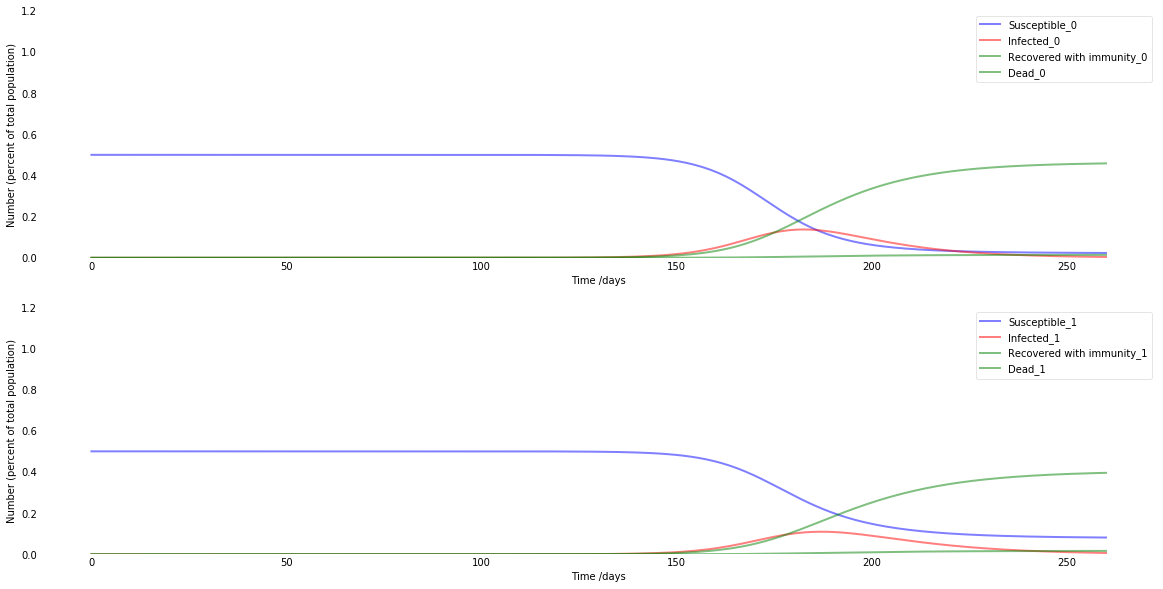

In [26]:
plot_multidim_solution(sol)

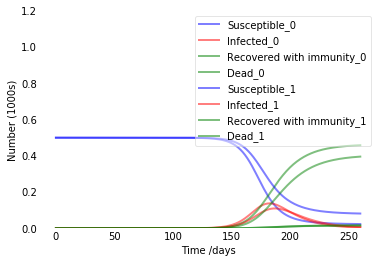

In [51]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
for i in range(ndim):
    ax.plot(sol.t, sol.y[i,:]/N, 'b', alpha=0.5, lw=2, label=f'Susceptible_{i}')
    ax.plot(sol.t, sol.y[ndim+i,:]/N, 'r', alpha=0.5, lw=2, label=f'Infected_{i}')
    
    ax.plot(sol.t, sol.y[2*ndim+i,:]/N, 'g', alpha=0.5, lw=2, label=f'Recovered with immunity_{i}')
    
    ax.plot(sol.t, sol.y[3*ndim+i,:]/N, 'g', alpha=0.5, lw=2, label=f'Dead_{i}')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

Enhancements to the simulation:
    - make parameters $\beta, \gamma, \delta$ time dependent as done in the RKI paper
    - solve the system for more than 2 groups 
    - fit the system on actual data (problem is that we have to assume to be somewhere on the ascending part of the curve but we don't know where)